# QN with RBF features

This notebook implements Radial Basis Functions as features (from section 9.5.5 Radial Basis Functions, Sutton and Barto intro to RL book) for a simplified QN model.

The environment is the mountain car: a car is place at the bottom of a valley and it has the goal of reaching the top of the right hill, so it has to learn to accelerate strategically depending on the states defined by position and current velocity. It can take 3 actions: do nothing, accelerate left, accelerate right. So the policy maps (position,velocity) to acceleration(left, no accelerate, right)

The idea is to use an RBF network to calculate features which are the input of a function approximator for the Q(s,a) function, the Q function is a linear regression model on top of the RBF features. Instead of calculating the RBF features manually, sklearns RBFSampler will be used with different scale parameters via sklearns FeatureUnion.

In this example the prototypical(or center states) of the RBFs are obtained sampling the state space of the environment, the number of RBF features is a hyperparameter and the best scale parameter/variance(for every RBF) is unclear so 4 different values are used.

According to Sutton And Barto book(section 9.5.5):

<img src="../animations/rlbookRBFs.png">

In [1]:
import gym
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor
from PIL import Image
import pandas as pd

## Preprocessing and feature eng.

In this section all functions related to processing the data(an calculating features are created)

In [2]:
class FeatureTransformer:
    """Performs the rbf feature calculator for the states"""
    def __init__(self,env:gym.Env,sample_size,rbf_components):
        """
            env: the openAI gym environment
            sample_size: number of random samples from the state space to create the RBF features
            rbf_components: the number of rbf components used for every variance
        """
        state_samples = np.array([env.observation_space.sample() for _ in range(sample_size)]) # used to train the RBF monte carlo sampler
        # create the standard scaler normalizer the state samples
        self.scaler = StandardScaler()
        self.scaler.fit(state_samples)

        # now "train" a RBF sampler using 4 different variances, with k different components each
        self.rbf_transformer = FeatureUnion([
            ("rbf1",RBFSampler(gamma=5.0, n_components=rbf_components)),
            ("rbf2",RBFSampler(gamma=2.0, n_components=rbf_components)),
             ("rbf3",RBFSampler(gamma=1.0, n_components=rbf_components)),
            ("rbf4",RBFSampler(gamma=0.5, n_components=rbf_components)),
        ])
        self.rbf_transformer.fit(self.scaler.transform(state_samples))

    def transform(self, states):
        """Transform the states to rbf features"""
        normalized_states = self.scaler.transform(states)
        return self.rbf_transformer.transform(normalized_states)
    
    


## Q Learning with function approximation

In this section we create the function approximator for the Q function(linear regression) and related functions(including plots)

In [3]:
class QModel:
    def __init__(self, env:gym.Env,state_transformer:FeatureTransformer, learning_rate) -> None:
        self.env = env
        self.models = []
        self.state_transformer = state_transformer

        # we have one function approximator for each action
        for i in range(env.action_space.n):
            # the SGD regressor returns an error if used without at least one step of training
            ## and the q learning algorithm uses it before it's first update
            ## so in this section we train a dummy step with partial fit
            ## since this environmnet has negative rewards using 0 as target is similar to perform "optimistic initial values"
            model = SGDRegressor(learning_rate=learning_rate)
            model.partial_fit(state_transformer.transform([env.reset()[0]]),[0])
            self.models.append(model)

    def predict(self,state):
        """Takes a state, calculates RBF features
            and predicts the approximation for the Q values
        """
        transformed_state = self.state_transformer.transform([state])
        return np.array([model.predict(transformed_state)[0] for model in self.models])
    
    def update(self, state, action, return_G):
        """
        performs a training step to the function approximator of a given action
        using the RBF values for a state as input and the observed return G as output
        """
        transformed_state = self.state_transformer.transform([state])
        self.models[action].partial_fit(transformed_state,[return_G])

    def select_action(self, state, epsilon):
        """perform epsilon-greedy action selection"""
        if np.random.random() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(state))
    

In [4]:
def plot_cost_to_go_function(environment:gym.Env, approximator: QModel, num_tiles = 30):
    """Sutton and Barto's book define cost to go as the negative of the V value function"""
    x_space = np.linspace(environment.observation_space.low[0],
                    environment.observation_space.high[0],
                    num=num_tiles)
    y_space = np.linspace(environment.observation_space.low[1],
                          environment.observation_space.high[1],
                          num=num_tiles)
    X_space, Y_space = np.meshgrid(x_space,y_space)

    # calculate cost to go(negative of V)
    Z = np.apply_along_axis(lambda _: -np.max(approximator.predict(_)),2,np.dstack([X_space,Y_space]))

    figure = plt.figure(figsize=(10,5))
    ax = figure.add_subplot(111,projection="3d")
    surface = ax.plot_surface(X_space,Y_space,Z,
                              rstride=1,cstride=1,cmap=matplotlib.cm.coolwarm,
                              vmin=-1,vmax=1.0)
    ax.set_xlabel("position")
    ax.set_ylabel("velocity")
    ax.set_zlabel("cost to to == -V(s)")
    ax.set_title("Cost to go")
    figure.colorbar(surface)
    plt.show()

In [5]:
def run_episode(environment:gym.Env,  qmodel:QModel,epsilon,gamma):
    state,_ = environment.reset()
    done = False
    total_reward = 0
    iterations = 0

    while not done and iterations < 10000 :
        action = qmodel.select_action(state,epsilon)
        new_state, reward, done, trunc, info = environment.step(action)

        G_return = reward + gamma*np.max(qmodel.predict(new_state))
        qmodel.update(state,action,G_return)

        total_reward+=reward
        iterations+=1

        state = new_state

    return total_reward,iterations

### Check an untrained agent

In [8]:
environment = gym.make("MountainCar-v0",render_mode="rgb_array")
rbf_sampler = FeatureTransformer(environment,10000,500)
q_model = QModel(environment,rbf_sampler,"constant")

state,_ = environment.reset()
done = False
total_reward = 0 
iterations = 0
epsilon = 0.0
renders = [] # will store the environment frames to create a gif later

while not done and iterations<=10000:
    action = q_model.select_action(state,epsilon)
    new_state, reward, done, trunc, info = environment.step(action)
    total_reward += reward
    frame = environment.render()
    renders.append(frame)
    
    if iterations % 1000 == 0:
        print(f"iteration {iterations} with total reward {total_reward}")
        
    state = new_state
    iterations += 1

print(f"Total reward {total_reward} in {iterations} iterations")

iteration 0 with total reward -1.0
iteration 1000 with total reward -1001.0
iteration 2000 with total reward -2001.0
iteration 3000 with total reward -3001.0
iteration 4000 with total reward -4001.0
iteration 5000 with total reward -5001.0
iteration 6000 with total reward -6001.0
iteration 7000 with total reward -7001.0
iteration 8000 with total reward -8001.0
iteration 9000 with total reward -9001.0
iteration 10000 with total reward -10001.0
Total reward -10001.0 in 10001 iterations


In [9]:
imgs = [Image.fromarray(img) for img in renders]
imgs[0].save("../animations/QLearningApproxRBFMountainUntrained.gif",save_all=True, append_images=imgs[1:],loop=0)

<img src="../animations/QLearningApproxRBFMountainUntrained.gif" width="750" align="center" loop=False>

In [10]:
EPISODES = 700
PRINT_EVERY = 10

environment = gym.make("MountainCar-v0",render_mode="rgb_array")
rbf_sampler = FeatureTransformer(environment,10000,500)
q_model = QModel(environment,rbf_sampler,"constant")

gamma  = 0.99 # disccount factor
epsilon_decay = 0.97 #
epsilon = 1.0 # start fully exploring

total_rewards = []
total_iterations = []

for episode_num in range(EPISODES):
    total_reward,iterations = run_episode(environment,q_model,epsilon,gamma)
    total_rewards.append(total_reward)
    total_iterations.append(iterations)
    

    if episode_num % PRINT_EVERY == 0:
        print(f"Episode {episode_num}, epsilon:{epsilon}, total_reward {total_reward}, {iterations} iterations")
    epsilon = epsilon*epsilon_decay if epsilon > 0.05 else 0.05
print(f"Mean reward for last 100 episodes:{np.array(total_rewards[-100:]).mean()}")

Episode 0, epsilon:1.0, total_reward -10000.0, 10000 iterations
Episode 10, epsilon:0.7374241268949281, total_reward -254.0, 254 iterations
Episode 20, epsilon:0.5437943429267471, total_reward -247.0, 247 iterations
Episode 30, epsilon:0.4010070685431576, total_reward -157.0, 157 iterations
Episode 40, epsilon:0.2957122873991326, total_reward -116.0, 116 iterations
Episode 50, epsilon:0.21806537534740741, total_reward -154.0, 154 iterations
Episode 60, epsilon:0.1608066690215767, total_reward -115.0, 115 iterations
Episode 70, epsilon:0.11858271750211788, total_reward -107.0, 107 iterations
Episode 80, epsilon:0.08744575691882718, total_reward -115.0, 115 iterations
Episode 90, epsilon:0.06448461094653227, total_reward -115.0, 115 iterations
Episode 100, epsilon:0.05, total_reward -113.0, 113 iterations
Episode 110, epsilon:0.05, total_reward -112.0, 112 iterations
Episode 120, epsilon:0.05, total_reward -109.0, 109 iterations
Episode 130, epsilon:0.05, total_reward -113.0, 113 iterati

## Plot performance plots

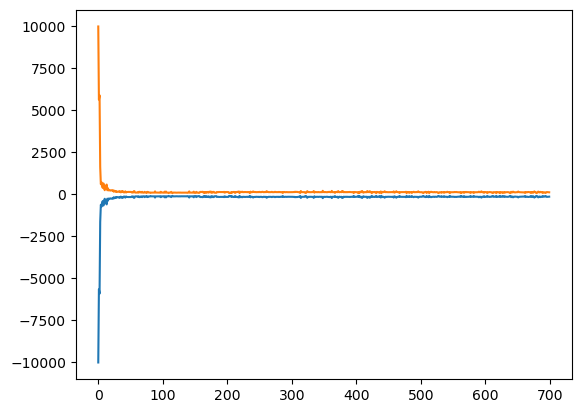

In [11]:
plt.plot(total_rewards)
plt.plot(total_iterations)
plt.show()

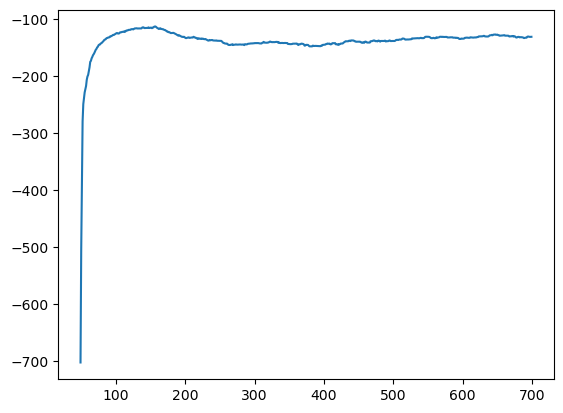

In [12]:
df = pd.DataFrame(data=total_rewards,columns=["reward"])
df["running_mean"] = df["reward"].rolling(window=50).mean()
plt.plot(df.running_mean)
plt.show()

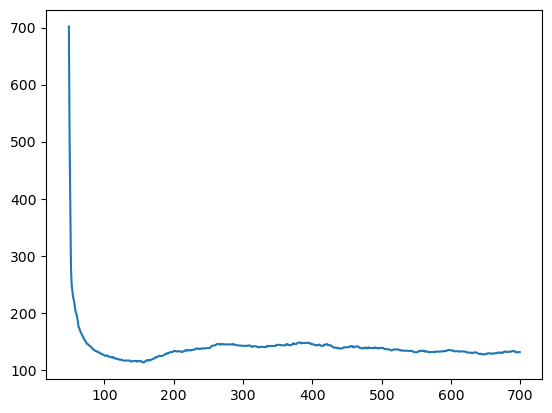

In [13]:
df = pd.DataFrame(data=total_iterations,columns=["iteration"])
df["running_mean"] = df["iteration"].rolling(window=50).mean()
plt.plot(df.running_mean)
plt.show()

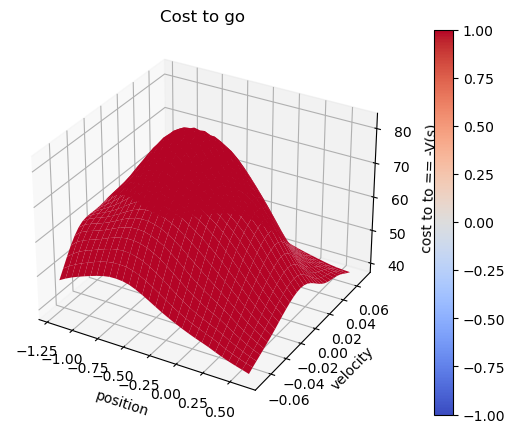

In [14]:
plot_cost_to_go_function(environment,q_model)

## Check a trained agent

In [15]:
state,_ = environment.reset()
done = False
total_reward = 0 
iterations = 0
epsilon = 0.00 # full exploit
renders = [] # will store the environment frames to create a gif later

while not done and iterations<=10000:
    action = q_model.select_action(state,epsilon)
    new_state, reward, done, trunc, info = environment.step(action)
    total_reward += reward
    frame = environment.render()
    renders.append(frame)
    
    if iterations % 1000 == 0:
        print(f"iteration {iterations} with total reward {total_reward}")
        
    state = new_state
    iterations += 1

print(f"Total reward {total_reward} in {iterations} iterations")

iteration 0 with total reward -1.0
Total reward -86.0 in 86 iterations


In [16]:
imgs = [Image.fromarray(img) for img in renders]
imgs[0].save("../animations/QLearningApproxRBFMountainTrained.gif",save_all=True, append_images=imgs[1:],loop=0)

<img src="../animations/QLearningApproxRBFMountainTrained.gif" width="750" align="center" loop=False>